In [1]:
"""
Training runfile

Date: October 2019
Author: Ignacio Heredia
Email: iheredia@ifca.unican.es
Github: ignacioheredia

Description:
This file contains the commands for training an audio classifier.

Additional notes:
* On the training routine: Preliminary tests show that using a custom lr multiplier for the lower layers yield to better
results than freezing them at the beginning and unfreezing them after a few epochs like it is suggested in the Keras
tutorials.
"""

#TODO List:

#TODO: Implement resuming training
#TODO: Try that everything works out with validation data
#TODO: Try several regularization parameters
#TODO: Add additional metrics for test time in addition to accuracy
#TODO: Implement additional techniques to deal with class imbalance (not only class_weigths)
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

import os
import time
import json
from datetime import datetime
import warnings

import numpy as np
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras.backend as K

from audioclas import paths, config, utils, model_utils
from audioclas.data_utils import load_data_splits, load_class_names, data_sequence, generate_embeddings,\
    file_to_PCM_16bits, json_friendly, save_embeddings_txt
from audioclas.model import ModelWrapper
from audioclas.optimizers import customAdam

# Set Tensorflow verbosity logs
tf.logging.set_verbosity(tf.logging.ERROR)

# Dynamically grow the memory used on the GPU (https://github.com/keras-team/keras/issues/4161)
gpu_options = tf.GPUOptions(allow_growth=True)
tfconfig = tf.ConfigProto(gpu_options=gpu_options)
sess = tf.Session(config=tfconfig)
K.set_session(sess)


CONF = config.get_conf_dict()
TIMESTAMP = datetime.now().strftime('%Y-%m-%d_%H%M%S')

CONF["general"]["dataset_directory"]='/storage/Imagine_UC6/data_new_ais/data50_extra'

CONF["training"]["use_early_stopping"]=True
CONF["training"]["batch_size"]=100
CONF["training"]["epochs"]=15

CONF["preprocessing"]["files_to_PCM"]=True
CONF["preprocessing"]["compute_embeddings"]=True

paths.timestamp = TIMESTAMP
paths.CONF = CONF

utils.create_dir_tree()
utils.backup_splits()
load_class_names(splits_dir=paths.get_ts_splits_dir())


2023-12-05 11:03:48.864454: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-05 11:03:48.895943: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


ModuleNotFoundError: No module named 'audioclas'

In [4]:
CONF["training"]["batch_size"]=50

In [2]:




# Load the training data
X_train, y_train = load_data_splits(splits_dir=paths.get_ts_splits_dir(),
                                    dataset_dir=paths.get_dataset_dir(),
                                    split_name='train')

# Load the validation data
if (CONF['training']['use_validation']) and ('val.txt' in os.listdir(paths.get_ts_splits_dir())):
    X_val, y_val = load_data_splits(splits_dir=paths.get_ts_splits_dir(),
                                    dataset_dir=paths.get_dataset_dir(),
                                    split_name='val')
else:
    print('No validation data.')
    X_val, y_val = None, None
    CONF['training']['use_validation'] = False

# Load the class names
class_names = 1 #load_class_names(splits_dir=paths.get_ts_splits_dir())

# Update the configuration
CONF['training']['batch_size'] = min(CONF['training']['batch_size'], len(X_train))

if CONF['model']['num_classes'] is None:
    CONF['model']['num_classes'] = 1#len(class_names)

# assert CONF['model']['num_classes'] >= np.amax(y_train),\
#     "Your train.txt file has more categories than those defined in classes.txt"
# if CONF['training']['use_validation']:
#     assert CONF['model']['num_classes'] >= np.amax(y_val),\
#         "Your val.txt file has more categories than those defined in classes.txt"

# Transform the training data to scipy-compatible 16-bit
if not CONF['preprocessing']['compute_embeddings']:  # no need to compute if embeddings are precomputed
    CONF['preprocessing']['files_to_PCM'] = False

if CONF['preprocessing']['files_to_PCM']:
    print('Transforming inputs to PCM 16-bits ...')
    for p in tqdm(X_train):
        file_to_PCM_16bits(p)
    if CONF['training']['use_validation']:
        for p in tqdm(X_val):
            file_to_PCM_16bits(p)

# Create model wrapper
model_wrap = ModelWrapper(classifier_model=os.path.join(paths.get_models_dir(), 'audioset', 'ckpts',
                                                        'final_model.h5'))

# Generating new embeddings if needed
if CONF['preprocessing']['compute_embeddings']:
    print('Clearing old embeddings ...')
    embed_dir = paths.get_embeddings_dir()
#     for f in os.listdir(embed_dir):
#         os.remove(os.path.join(embed_dir, f))

    print("Generating new embeddings ...")
    X_train, y_train = generate_embeddings(model_wrap=model_wrap, filepaths=X_train, labels=y_train)
    save_embeddings_txt(X_train, y_train, 'train_emb.txt')

    if CONF['training']['use_validation']:
        X_val, y_val = generate_embeddings(model_wrap=model_wrap, filepaths=X_val, labels=y_val)
        save_embeddings_txt(X_val, y_val, 'val_emb.txt')

else:
    if not X_train[0].endswith('.npy'):
        raise Exception("If you do not compute the embeddings, your train/val.txt should point to the"
                        "embeddings `.npy` files.")

# Create data generator for train and val sets
train_gen = data_sequence(X_train, y_train,
                          batch_size=CONF['training']['batch_size'],
                          num_classes=CONF['model']['num_classes'], shuffle=False)
train_steps = int(np.ceil(len(X_train)/CONF['training']['batch_size']))

if CONF['training']['use_validation']:
    val_gen = data_sequence(X_val, y_val,
                            batch_size=CONF['training']['batch_size'],
                            num_classes=CONF['model']['num_classes'], shuffle=False)
    val_steps = int(np.ceil(len(X_val)/CONF['training']['batch_size']))
else:
    val_gen = None
    val_steps = None

Loading train data...
new version
Loading val data...
new version


Exception: If you do not compute the embeddings, your train/val.txt should point to theembeddings `.npy` files.

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import Callback
from matplotlib.cm import get_cmap
class LinePlotCallback(Callback):
    def __init__(self, train_gen, val_gen, val_steps, class_names):
        super().__init__()
        self.train_gen = train_gen
        self.val_gen = val_gen
        self.val_steps = val_steps
        self.class_names = class_names
        self.epoch_count = 0
        self.colors = get_cmap('tab20').colors
        self.wout_avg_train = []
        self.wout_avg_val = []
        self.abs_diff_history_train = []
        self.abs_diff_history_val = []
        
        
        self.predicted_values_train=[]
        self.predicted_values_val=[]
        
        self.real_values_val=[]
        self.real_values_train=[]

    def save_predicted_values(self, generator, predicted_values_list, real_values_list, abs_diff_history_list,datapoints):
        predicted_values_epoch = []
        real_values_epoch = []

        for batch in range(len(generator)):
            batch_X, batch_y = generator[batch]
            batch_y_pred = self.model.predict(batch_X)
            predicted_values_epoch.append(batch_y_pred[0:datapoints])
            real_values_epoch.append(batch_y[0:datapoints])

            abs_diff = np.abs(batch_y - batch_y_pred)
            avg_abs_diff = np.mean(abs_diff)#, axis=0)
            abs_diff_history_list.append(avg_abs_diff)

        predicted_values_list.append(predicted_values_epoch)
        real_values_list.append(real_values_epoch)
        return predicted_values_list, real_values_list

    def transform_values(self,values):
            return [(10000 - 10000 * y) for y in values]
        
    def plot_batch_predicted_and_real(self, batch, predicted_values_list, real_values_list, save_dir, title, datapoints, is_validation=False):
        plt.figure(figsize=(20, 10))

        # Plot real values only once for each batch
        real_values = real_values_list[0][batch]
        names=[]
        for i in range(datapoints):
            names.append(f"dp {i}")

        real_values = self.transform_values(real_values)
        predicted_values_list = [self.transform_values(epoch_values) for epoch_values in predicted_values_list]


        plt.scatter(names, real_values, label='Real', alpha=0.7, color='black', marker='o', s=100)

        num_epochs = len(predicted_values_list)

        for epoch, predicted_values_epoch in enumerate(predicted_values_list):
            predicted_values = predicted_values_epoch[batch]
            color = self.colors[epoch % len(self.colors)]
#             marker = self.markers[epoch % len(self.markers)]
            alpha = 1-(1.0 - (epoch / (num_epochs)) )
            alpha= (epoch + 1) / num_epochs 
            plt.scatter(names, predicted_values, label=f'Epoch {epoch + 1}, Predicted', alpha=alpha, color=color)

        plt.ylim(0, 10000)
        plt.xlabel('Class Names')
        plt.ylabel('Values')
        plt.legend()
        plt.title(title)

        if is_validation:
            plt.savefig(os.path.join(save_dir, f'validation_batch_{batch}.png'))
        else:
            plt.savefig(os.path.join(save_dir, f'training_batch_{batch}.png'))

        plt.close()

    def plot_values_for_iterations(self, wout_avg, abs_diff_history, save_dir, title, is_validation=False):
        plt.figure(figsize=(20, 10))

        num_iterations = len(wout_avg)
        num_classes = len(self.class_names)

        # Create a DataFrame from the list
        iterations = [f'Iteration {i + 1}' for i in range(num_iterations)]

        for i in range(len(self.class_names)):
            plt.plot(range(num_iterations), [wout_avg[j][i] for j in range(num_iterations)], label=self.class_names[i])

        # Set x-tick labels
        plt.xticks(range(num_iterations), iterations)

        # Add a legend
        plt.legend()

        # Set labels and title
        plt.xlabel('Iterations')
        plt.ylabel('Values')
        plt.title(title)

        if is_validation:
            plt.savefig(os.path.join(save_dir, f'{title}_validation.png'))
        else:
            plt.savefig(os.path.join(save_dir, f'{title}_training.png'))

        plt.close()

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_count = epoch

    def on_epoch_end(self, epoch, logs=None):
        # Save predicted values for training and validation
#         predicted_values_train = []
#         real_values_train = []
        abs_diff_history_train = []
#         predicted_values_val = []
#         real_values_val = []
        abs_diff_history_val = []
        datapoints=10
        self.predicted_values_train,self.real_values_train= self.save_predicted_values(self.train_gen, self.predicted_values_train, self.real_values_train, abs_diff_history_train,datapoints)
        self.predicted_values_val,self.real_values_val=self.save_predicted_values(self.val_gen, self.predicted_values_val, self.real_values_val, abs_diff_history_val,datapoints)

        # Plot batch predicted values and real values for training and validation
        save_dir = paths.get_plots_dir()  # Replace with your actual directory path

        for batch in range(len(self.predicted_values_train[0])):
            self.plot_batch_predicted_and_real(
                batch, self.predicted_values_train, self.real_values_train,
                save_dir, f'Batch {batch} Predicted and Real Values for Training', datapoints,is_validation=False
            )

        for batch in range(len(self.predicted_values_val[0])):
            self.plot_batch_predicted_and_real(
                batch, self.predicted_values_val, self.real_values_val,
                save_dir, f'Batch {batch} Predicted and Real Values for Validation',datapoints, is_validation=True
            )

#         # Transpose the abs_diff_history to get per-label data
#         avg_abs_diff_history_train = np.array(abs_diff_history_train).T
#         avg_abs_diff_history_val = np.array(abs_diff_history_val).T

#         self.wout_avg_train.append(np.mean(avg_abs_diff_history_train))
#         self.wout_avg_val.append(np.mean(avg_abs_diff_history_val))

#         # Plot values for different iterations
#         self.plot_values_for_iterations(
#             self.wout_avg_train, abs_diff_history_train,
#             save_dir, 'Values for Different Iterations for Training', is_validation=False
#         )

#         self.plot_values_for_iterations(
#             self.wout_avg_val, abs_diff_history_val,
#             save_dir, 'Values for Different Iterations for Validation', is_validation=True
#         )


In [4]:


# Launch the training
t0 = time.time()

# Create the model and compile it
model, base_model = model_utils.create_model(CONF, base_model=model_wrap.classify_model)

# Get a list of the top layer variables that should not be applied a lr_multiplier
base_vars = [var.name for var in base_model.trainable_variables]
all_vars = [var.name for var in model.trainable_variables]
top_vars = set(all_vars) - set(base_vars)
top_vars = list(top_vars)

# Set trainable layers
if CONF['training']['mode'] == 'fast':
    for layer in base_model.layers:
        layer.trainable = False
        
model.compile(optimizer=customAdam(lr=CONF['training']['initial_lr'],
                                   amsgrad=True,
                                   lr_mult=0.1,
                                   excluded_vars=top_vars
                                   ),
              loss='mean_squared_error',
              metrics=['mae', 'mse'])



line_plot_callback = LinePlotCallback(train_gen,val_gen, val_steps, class_names)  # Initialize the callback

# Include the custom callback in your list of callbacks
callbacks = utils.get_callbacks(CONF)
# callbacks.append(bar_plot_callback)
callbacks.append(line_plot_callback)

history = model.fit_generator(generator=train_gen,
                              steps_per_epoch=train_steps,
                              epochs=CONF['training']['epochs'],
                              class_weight=None,
                              validation_data=val_gen,
                              validation_steps=val_steps,
                              callbacks=callbacks,
                              verbose=1, max_queue_size=5, workers=4,
                              use_multiprocessing=CONF['training']['use_multiprocessing'],
                              initial_epoch=0)


# Saving everything
print('Saving data to {} folder.'.format(paths.get_timestamped_dir()))
print('Saving training stats ...')
stats = {'epoch': history.epoch,
         'training time (s)': round(time.time()-t0, 2),
         'timestamp': TIMESTAMP}
stats.update(history.history)
stats = json_friendly(stats)
stats_dir = paths.get_stats_dir()
with open(os.path.join(stats_dir, 'stats.json'), 'w') as outfile:
    json.dump(stats, outfile, sort_keys=True, indent=4)

print('Saving the configuration ...')
model_utils.save_conf(CONF)

print('Saving the model to h5...')
fpath = os.path.join(paths.get_checkpoints_dir(), 'final_model.h5')
model.save(fpath)

# print('Saving the model to protobuf...')
# fpath = os.path.join(paths.get_checkpoints_dir(), 'final_model.proto')
# model_utils.save_to_pb(model, fpath)

print('Finished')







NameError: name 'train_gen' is not defined

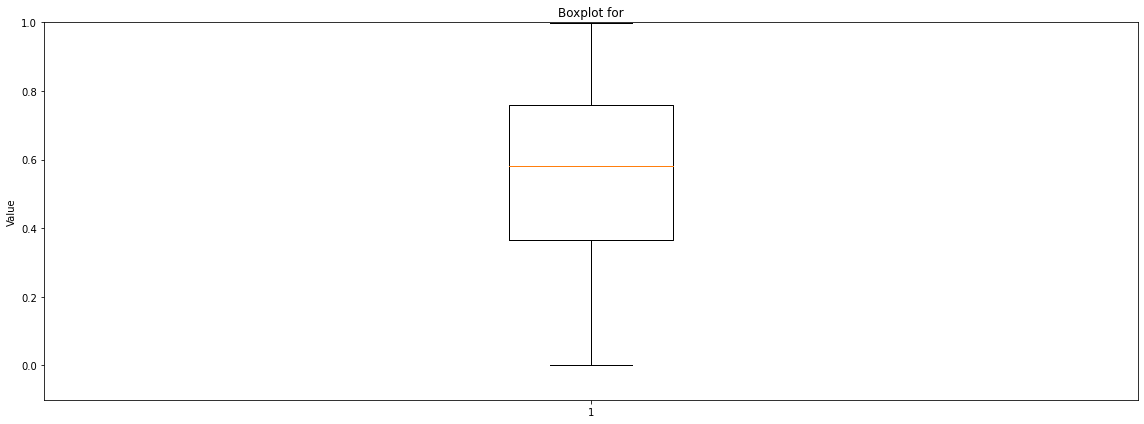

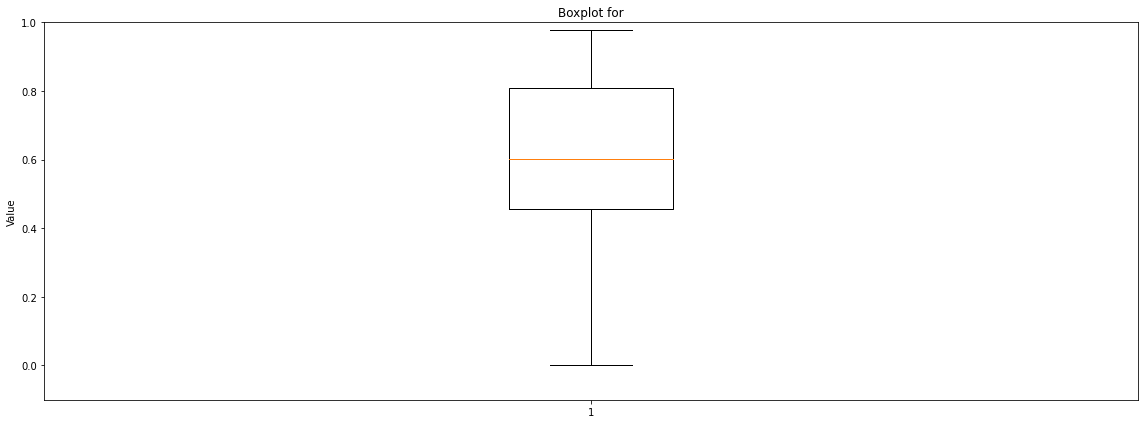

In [12]:
plt.figure(figsize=(16, 6))  # Adjust the figsize as needed

# Plot boxplots for each label

plt.boxplot(y_train)
plt.title(f'Boxplot for')
plt.ylim(-0.1, 1)  # Set y-axis limit from 0 to 1
plt.ylabel('Value')

plt.tight_layout()  # Ensure proper spacing
plt.show()


plt.figure(figsize=(16, 6))  # Adjust the figsize as needed

# Plot boxplots for each label

plt.boxplot(y_val)
plt.title(f'Boxplot for')
plt.ylim(-0.1, 1)  # Set y-axis limit from 0 to 1
plt.ylabel('Value')

plt.tight_layout()  # Ensure proper spacing
plt.show()


In [11]:
y_train

array([0.562, 0.046, 0.084, ..., 0.605, 0.574, 0.777], dtype=float32)